1593
样本数: 1593 像素数: 256


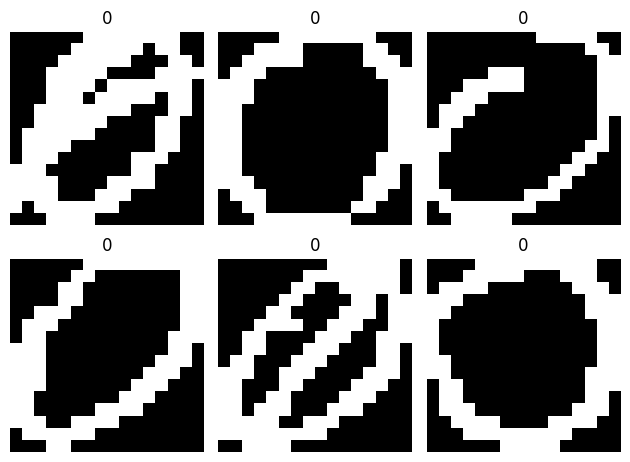

In [45]:
import numpy as np
import matplotlib.pyplot as plt #注意依赖库的安装

raw = np.loadtxt('semeion.data')
X, y = raw[:, :256], raw[:, 256:]
y = np.argmax(y, axis=1)          # 独热 → 0~9 整数
print(len(y))
print('样本数:', len(X), '像素数:', X.shape[1])

# 随机画 6 张图
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].reshape(16,16), cmap='gray')
    plt.title(y[i]); plt.axis('off')
plt.tight_layout(); plt.show()

In [46]:
#我想要将X和y划分为训练集和测试集
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=41)

In [47]:
#我将把KNN和CNN结合起来

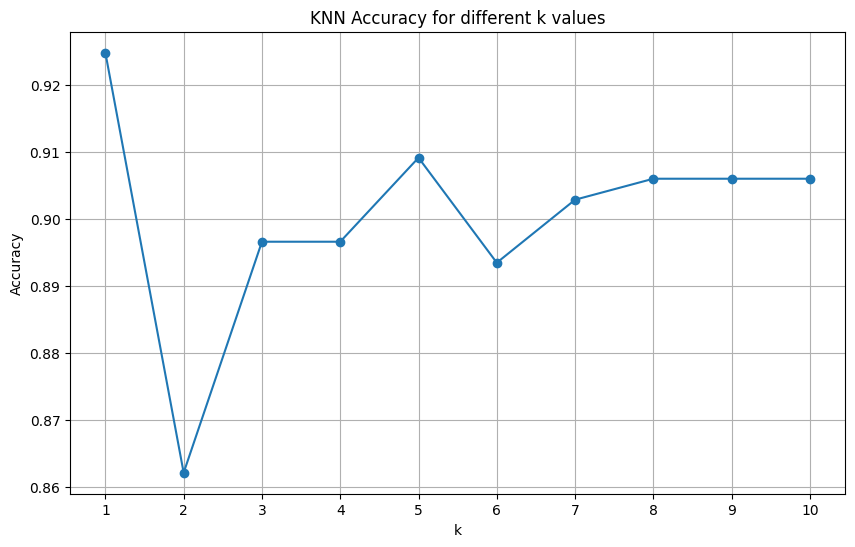

Best k: 1
Best accuracy: 0.9247648902821317


In [48]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# 测试不同的k值
k_range = range(1, 11)
accuracies = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracies.append(knn.score(X_test, y_test))

# 绘制准确率曲线
plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracies, marker='o')
plt.title('KNN Accuracy for different k values')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# 打印最佳k值和准确率
best_k = k_range[np.argmax(accuracies)]
print(f"Best k: {best_k}")
print(f"Best accuracy: {max(accuracies)}")


In [54]:
# 有监督CNN+KNN实现
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

# 检查设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

# 简化的CNN特征提取器 - 针对16x16手写数字优化
class SimplifiedCNNFeatureExtractor(nn.Module):
    """
    简化的CNN特征提取器
    专门为16x16手写数字设计，减少参数和复杂度
    """
    def __init__(self, num_classes=10, feature_dim=32):
        super(SimplifiedCNNFeatureExtractor, self).__init__()
        
        # 简化的卷积层 - 只用两层
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 减少通道数
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 进一步减少
        
        # 批量归一化
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        
        # 池化和dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)  # 降低dropout率
        
        # 简化的全连接层
        # 经过两次池化后：16x16 -> 8x8 -> 4x4
        self.fc1 = nn.Linear(32 * 4 * 4, 128)  # 减少中间层大小
        self.feature_layer = nn.Linear(128, feature_dim)  # 特征层
        self.classifier = nn.Linear(feature_dim, num_classes)  # 分类层
        
    def forward(self, x, return_features=False):
        # 卷积特征提取
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 16x16 -> 8x8
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 8x8 -> 4x4
        
        # 展平
        x = x.view(-1, 32 * 4 * 4)
        
        # 全连接层
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        features = F.relu(self.feature_layer(x))  # 特征层
        
        if return_features:
            return features
            
        # 分类输出
        output = self.classifier(features)
        return output, features

# 数据预处理
def prepare_data_supervised(X_train, X_test, y_train, y_test):
    """
    数据预处理，包括标准化和张量转换
    """
    # 数据标准化
    X_train_norm = (X_train - X_train.mean()) / (X_train.std() + 1e-8)
    X_test_norm = (X_test - X_train.mean()) / (X_train.std() + 1e-8)
    
    # 转换为张量
    X_train_tensor = torch.FloatTensor(X_train_norm.reshape(-1, 1, 16, 16))
    X_test_tensor = torch.FloatTensor(X_test_norm.reshape(-1, 1, 16, 16))
    y_train_tensor = torch.LongTensor(y_train)
    y_test_tensor = torch.LongTensor(y_test)
    
    # 创建数据加载器
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    return train_loader, test_loader, X_train_tensor, X_test_tensor

# 有监督训练函数
def train_supervised_cnn(model, train_loader, num_epochs=20):  # 增加训练轮数
    """
    有监督训练CNN模型
    """
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)  # 调整学习率调度
    
    print("开始有监督训练简化CNN...")
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            # 前向传播
            outputs, features = model(data)
            loss = criterion(outputs, targets)
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        scheduler.step()
        
        if (epoch + 1) % 5 == 0:  # 每5轮输出一次
            accuracy = 100. * correct / total
            avg_loss = running_loss / len(train_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    print("简化CNN训练完成!")
    return model

# 创建简化模型和准备数据
print("创建简化CNN模型和准备数据...")
cnn_model = SimplifiedCNNFeatureExtractor(num_classes=10, feature_dim=32).to(device)  # 减少特征维度
train_loader, test_loader, X_train_tensor, X_test_tensor = prepare_data_supervised(X_train, X_test, y_train, y_test)

print(f"模型参数总数: {sum(p.numel() for p in cnn_model.parameters())}")
print(f"训练数据形状: {X_train_tensor.shape}")
print(f"测试数据形状: {X_test_tensor.shape}")

使用设备: cpu
创建简化CNN模型和准备数据...
模型参数总数: 75018
训练数据形状: torch.Size([1274, 1, 16, 16])
测试数据形状: torch.Size([319, 1, 16, 16])


In [55]:
# 训练简化的CNN特征提取器
print("=" * 50)
print("开始训练简化的CNN特征提取器")
print("=" * 50)

# 训练简化的CNN模型
trained_cnn = train_supervised_cnn(cnn_model, train_loader, num_epochs=20)

开始训练简化的CNN特征提取器
开始有监督训练简化CNN...
Epoch [5/20], Loss: 0.1679, Accuracy: 96.47%
Epoch [5/20], Loss: 0.1679, Accuracy: 96.47%
Epoch [10/20], Loss: 0.0533, Accuracy: 98.74%
Epoch [10/20], Loss: 0.0533, Accuracy: 98.74%
Epoch [15/20], Loss: 0.0227, Accuracy: 99.84%
Epoch [15/20], Loss: 0.0227, Accuracy: 99.84%
Epoch [20/20], Loss: 0.0146, Accuracy: 99.76%
简化CNN训练完成!
Epoch [20/20], Loss: 0.0146, Accuracy: 99.76%
简化CNN训练完成!


In [56]:
#我现在想要提取特征并使用KNN进行分类
def extract_features(model,data_loader):#loader的意思是数据加载器
    model.eval()#eval的缩写是evaluation，作用是将模型设置为评估模式，即关闭dropout和batch normalization等训练时特有的操作
    features = []
    with torch.no_grad():#不需要计算梯度
        for data, _ in data_loader:
            data = data.to(device)
            feature = model(data, return_features=True)
            features.append(feature.cpu().numpy())#将特征从GPU转移到CPU，并转换为numpy数组
    return np.concatenate(features, axis=0)#将所有批次的特征沿第0轴连接起来，形成一个完整的特征矩阵
# 提取训练和测试特征
train_features = extract_features(trained_cnn, train_loader)
test_features = extract_features(trained_cnn, test_loader)
print(f"训练特征形状: {train_features.shape}")
print(f"测试特征形状: {test_features.shape}")


训练特征形状: (1274, 32)
测试特征形状: (319, 32)


In [52]:
class KNNwithFeatures:
    def __init__(self, n_neighbors=3):
        self.knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    def fit(self, X, y):
        self.knn.fit(X, y)
    
    def predict(self, X):
        return self.knn.predict(X)
    
    def score(self, X, y):
        return self.knn.score(X, y)

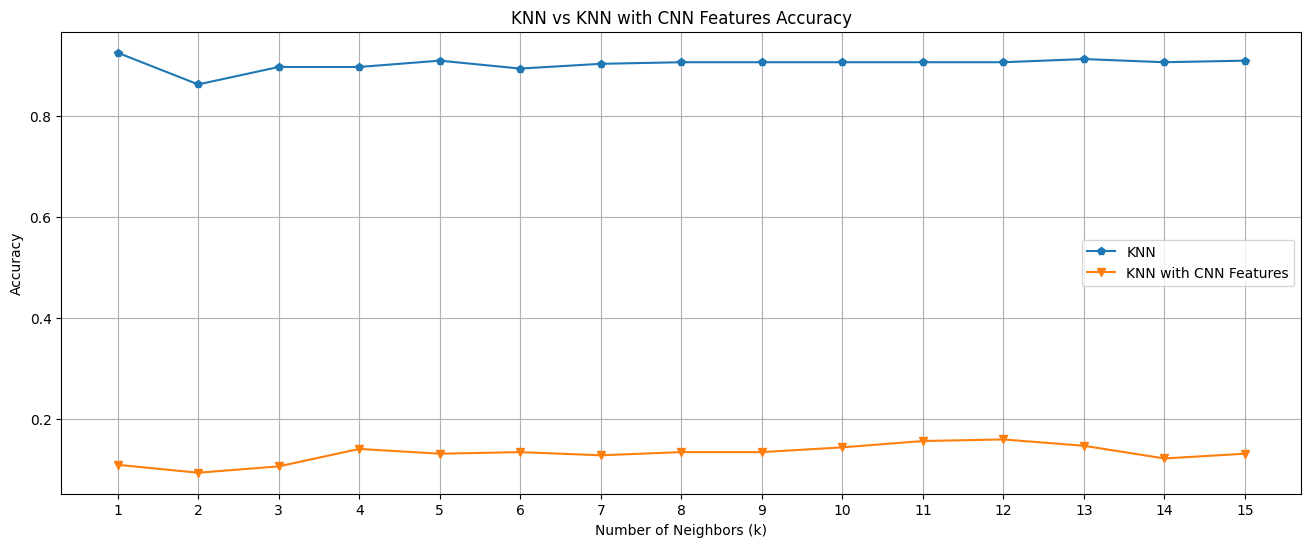

In [57]:
#我将使用KNN和KNN_withFeatures在不同的K下的对比
k_values = range(1,16)
knn_accuracies = []
knn_feat_accuracies = []
for k in k_values:
    # 传统KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_accuracies.append(knn.score(X_test, y_test))
    
    # KNN with CNN features
    knn_feat = KNNwithFeatures(n_neighbors=k)
    knn_feat.fit(train_features, y_train)
    knn_feat_accuracies.append(knn_feat.score(test_features, y_test))
# 绘制结果对比
plt.figure(figsize = (16, 6))
plt.plot(k_values, knn_accuracies, marker='p', label='KNN')
plt.plot(k_values, knn_feat_accuracies, marker='v', label='KNN with CNN Features')
plt.title('KNN vs KNN with CNN Features Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()


Creating feature distribution plots...
Computing t-SNE...
Computing PCA...
Computing PCA...


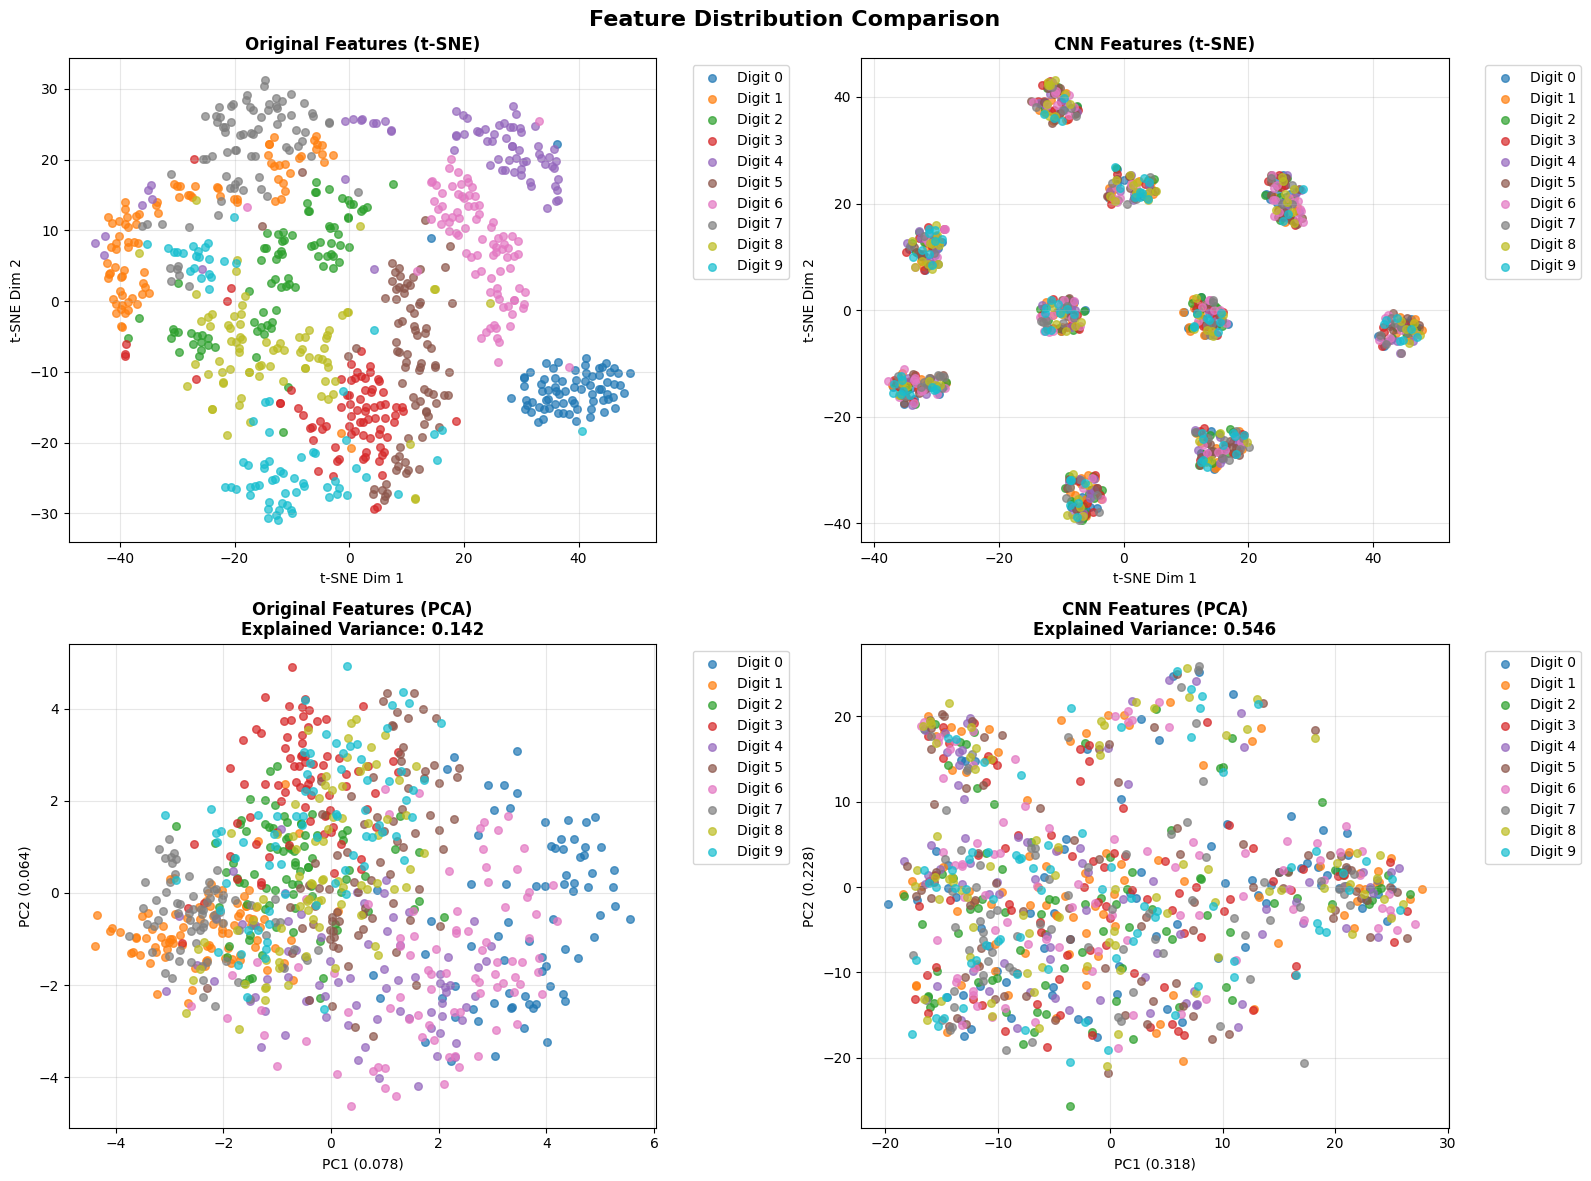


Calculating separation metrics...

Feature Quality Analysis:

Original Features:
  Inter-class distance: 4.699
  Intra-class distance: 6.566
  Separation ratio: 0.716

CNN Features:
  Inter-class distance: 3.644
  Intra-class distance: 22.065
  Separation ratio: 0.165

Improvement: -76.92%
CNN features are WORSE


In [64]:
# Feature Distribution Visualization
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

print("Creating feature distribution plots...")

# Sampling for efficiency
n_samples = 800
indices = np.random.choice(len(X_train), n_samples, replace=False)
X_subset = X_train[indices]
y_subset = y_train[indices]
cnn_features_subset = train_features[indices]

# Dimensionality reduction
print("Computing t-SNE...")
tsne_original = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_original = tsne_original.fit_transform(X_subset)

tsne_cnn = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_cnn = tsne_cnn.fit_transform(cnn_features_subset)

print("Computing PCA...")
pca_original = PCA(n_components=2, random_state=42)
X_pca_original = pca_original.fit_transform(X_subset)

pca_cnn = PCA(n_components=2, random_state=42)
X_pca_cnn = pca_cnn.fit_transform(cnn_features_subset)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Distribution Comparison', fontsize=16, fontweight='bold')
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Plot 1: Original features t-SNE
ax1 = axes[0, 0]
for i in range(10):
    mask = y_subset == i
    ax1.scatter(X_tsne_original[mask, 0], X_tsne_original[mask, 1], 
               c=[colors[i]], label=f'Digit {i}', alpha=0.7, s=30)
ax1.set_title('Original Features (t-SNE)', fontsize=12, fontweight='bold')
ax1.set_xlabel('t-SNE Dim 1')
ax1.set_ylabel('t-SNE Dim 2')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: CNN features t-SNE
ax2 = axes[0, 1]
for i in range(10):
    mask = y_subset == i
    ax2.scatter(X_tsne_cnn[mask, 0], X_tsne_cnn[mask, 1], 
               c=[colors[i]], label=f'Digit {i}', alpha=0.7, s=30)
ax2.set_title('CNN Features (t-SNE)', fontsize=12, fontweight='bold')
ax2.set_xlabel('t-SNE Dim 1')
ax2.set_ylabel('t-SNE Dim 2')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Original features PCA
ax3 = axes[1, 0]
for i in range(10):
    mask = y_subset == i
    ax3.scatter(X_pca_original[mask, 0], X_pca_original[mask, 1], 
               c=[colors[i]], label=f'Digit {i}', alpha=0.7, s=30)
var_ratio = pca_original.explained_variance_ratio_
ax3.set_title(f'Original Features (PCA)\nExplained Variance: {var_ratio.sum():.3f}', 
              fontsize=12, fontweight='bold')
ax3.set_xlabel(f'PC1 ({var_ratio[0]:.3f})')
ax3.set_ylabel(f'PC2 ({var_ratio[1]:.3f})')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# Plot 4: CNN features PCA
ax4 = axes[1, 1]
for i in range(10):
    mask = y_subset == i
    ax4.scatter(X_pca_cnn[mask, 0], X_pca_cnn[mask, 1], 
               c=[colors[i]], label=f'Digit {i}', alpha=0.7, s=30)
var_ratio_cnn = pca_cnn.explained_variance_ratio_
ax4.set_title(f'CNN Features (PCA)\nExplained Variance: {var_ratio_cnn.sum():.3f}', 
              fontsize=12, fontweight='bold')
ax4.set_xlabel(f'PC1 ({var_ratio_cnn[0]:.3f})')
ax4.set_ylabel(f'PC2 ({var_ratio_cnn[1]:.3f})')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature Separation Analysis
def calculate_separation_metrics(features, labels):
    inter_distances = []
    intra_distances = []
    
    for i in range(10):
        class_features = features[labels == i]
        class_center = np.mean(class_features, axis=0)
        
        # Intra-class distance
        intra = np.linalg.norm(class_features - class_center, axis=1)
        intra_distances.extend(intra)
        
        # Inter-class distance
        for j in range(i+1, 10):
            other_center = np.mean(features[labels == j], axis=0)
            inter_distances.append(np.linalg.norm(class_center - other_center))
    
    return np.mean(inter_distances), np.mean(intra_distances)

print("\nCalculating separation metrics...")
original_inter, original_intra = calculate_separation_metrics(X_subset, y_subset)
cnn_inter, cnn_intra = calculate_separation_metrics(cnn_features_subset, y_subset)

sep_ratio_orig = original_inter / original_intra
sep_ratio_cnn = cnn_inter / cnn_intra

print(f"\n{'='*50}")
print(f"Feature Quality Analysis:")
print(f"{'='*50}")
print(f"\nOriginal Features:")
print(f"  Inter-class distance: {original_inter:.3f}")
print(f"  Intra-class distance: {original_intra:.3f}")
print(f"  Separation ratio: {sep_ratio_orig:.3f}")
print(f"\nCNN Features:")
print(f"  Inter-class distance: {cnn_inter:.3f}")
print(f"  Intra-class distance: {cnn_intra:.3f}")
print(f"  Separation ratio: {sep_ratio_cnn:.3f}")
print(f"\nImprovement: {((sep_ratio_cnn - sep_ratio_orig) / sep_ratio_orig * 100):+.2f}%")
print(f"CNN features are {'BETTER' if sep_ratio_cnn > sep_ratio_orig else 'WORSE'}")
print(f"{'='*50}")
